# Import flexiblecc and get calibration dataset
If it is installt we can import else install it with pip 

In [1]:
import os

In [2]:
try:
    import flexiblecc as fcc
except ImportError as e:
    !pip install flexiblecc
    import flexiblecc as fcc

Now let's get the dataset if it is not allready pressent 

In [3]:
if not os.path.exists("../CalImgs/"):
    if not os.path.exists("Flexible-Camera-Calibration/CalImgs"):
        !git clone https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration 
    datasetpath = "Flexible-Camera-Calibration/CalImgs/Checkerboard/DTU/cam_0*"
else:
    datasetpath = "../CalImgs/Checkerboard/DTU/cam_0*"

Next we can import a copuel of package we will need

In [4]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Image data 
A calibration dataset is locatet in Flexible-Camera-Calibration/CalImgs (taken from http://roboimagedata.compute.dtu.dk/)
There is bouth color and gray image.
Lets load the color images and then convert them to gray to have as moush of the pipline in the example

In [5]:
color_cal_imgs_files = glob.glob(datasetpath)
color_cal_imgs = np.array([cv2.imread(f) for f in tqdm(color_cal_imgs_files)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:04<00:00, 18.96it/s]


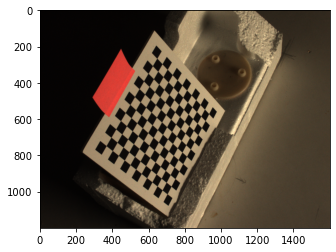

In [6]:
plt.figure()
plt.imshow(cv2.cvtColor(color_cal_imgs[0], cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
gray_cal_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in tqdm(color_cal_imgs)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 1957.92it/s]


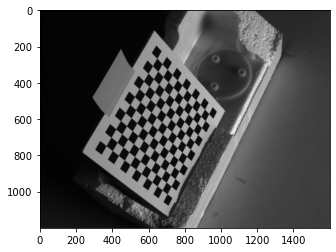

In [8]:
plt.figure()
plt.imshow(gray_cal_imgs[0], cmap="gray")
plt.show()

# Parametric Camera Calibration 
The chessboard used in the dataset is a 12x12 chessboard so we sets the pattern_size to (12, 12)

In [9]:
pattern_size = (12, 12)

In [10]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs, stdDeviationsIntrinsics, stdDeviationsExtrinsics, perViewErrors, obj_points, img_points = fcc.Parametric.calibrate_camera_chessboard(gray_cal_imgs, pattern_size, verbose=1)

  2%|████▊                                                                                                                                                                                                                            | 2/94 [00:00<00:05, 18.01image/s]

Finding chessboard pattern in the images


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.43image/s]


Doing camera calibrate


OldSchoolCC.calibrate_camera will give a lot of outputs.

Here is a small overview of the outputs:

In [11]:
print("RMS re-projection error in pixels", retval)
print("3x3 camera matrix:", cameraMatrix)
print("Distortion coefficients", distCoeffs)
print(f"Rotation vectors estimated for each pattern view. There are {len(rvecs)}. Example:", rvecs[0])
print(f"Translation vectors estimated for each pattern view. There are {len(tvecs)}. Example:", tvecs[0])
print(f"Standard deviations estimated for intrinsic parameters. There are {len(stdDeviationsIntrinsics)}. Example:", stdDeviationsIntrinsics[0])
print(f"Standard deviations estimated for extrinsic parameters. There are {len(stdDeviationsExtrinsics)}. Example:", stdDeviationsExtrinsics[0])
print(f"Vector of the RMS re-projection error estimated for each pattern view. There are {len(perViewErrors)}. Example:", perViewErrors[0])

RMS re-projection error in pixels 0.09258549838205704
3x3 camera matrix: [[2.89099220e+03 0.00000000e+00 8.24326073e+02]
 [0.00000000e+00 2.88229115e+03 5.63283448e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients [[ 2.03288270e+00  4.52548448e+01 -7.73226736e-03  1.80779861e-02
  -1.47886929e+02  2.09683329e+00  4.65342697e+01 -1.51419436e+02
  -1.83082177e-02 -1.92297600e-03  9.86103858e-03  7.83822797e-03
   6.18311558e-03  3.67951499e-02]]
Rotation vectors estimated for each pattern view. There are 94. Example: [[-0.13177674]
 [-0.82337607]
 [ 0.59110117]]
Translation vectors estimated for each pattern view. There are 94. Example: [[-3.4483962 ]
 [-5.76877002]
 [56.17491035]]
Standard deviations estimated for intrinsic parameters. There are 18. Example: [1.44125854]
Standard deviations estimated for extrinsic parameters. There are 564. Example: [0.00186111]
Vector of the RMS re-projection error estimated for each pattern view. There are 94. Example: [0.0

# Chessboards

Let's see where the chessboard was in relation to the camera

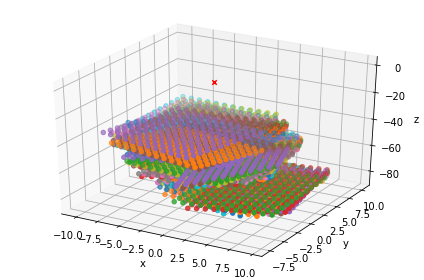

In [12]:
plt.figure()
fcc.Metrics.rtvecs_illustration.draw_rtvecs(rvecs, tvecs, obj_points[:,0,:])
plt.tight_layout()
plt.show()

# Distorsen plot
Now let's plot the distorsen we have found with the old-school method

In [13]:
def undistort(points):
    return cv2.undistortPoints(points, cameraMatrix, distCoeffs, P=cameraMatrix).reshape(-1, 2)

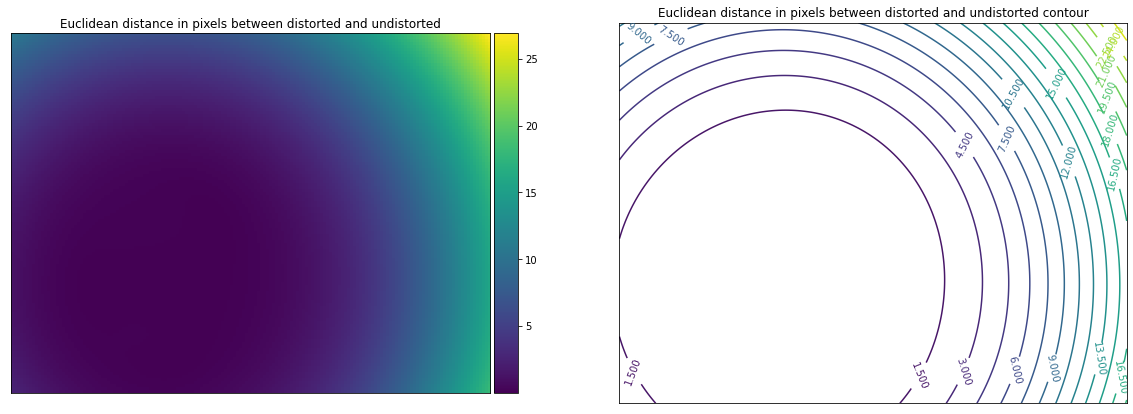

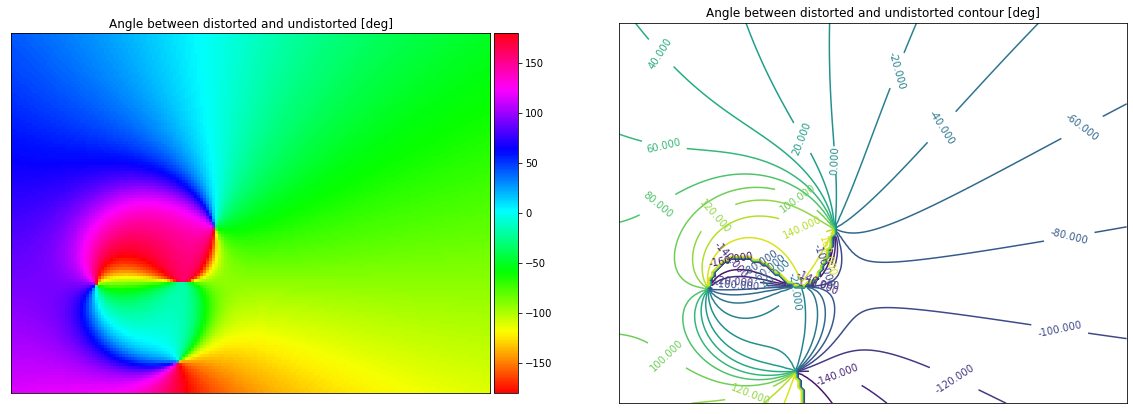

In [14]:
fcc.Metrics.plot_distort(undistort, gray_cal_imgs[0].shape, contour_n_levels=20)

# Voronoi diagram

We can also look for patterns in a Voronoi diagram over the angle between the feature points and the reprojected points as it will indicate a systematic error is present in the model of the camera

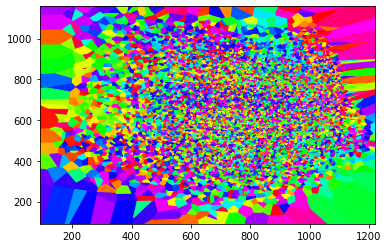

In [15]:
img_points_all, diff_all, angels_all, mag_all = fcc.Metrics.voronoi.projectPoints_and_cal_angles_and_mag(img_points, obj_points, rvecs, tvecs, cameraMatrix, distCoeffs)
    
plt.figure()
fcc.Metrics.voronoi.plot_voronoi(img_points_all, angels_all)
plt.show()